In [1]:
# import packages (will be added more as necessary)

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
# import framingham dataset and make dataframe
df = pd.read_csv('framingham.csv', delimiter = ',')

In [3]:
# high-level summary of the initial dataframe

# size(total # of data/cells)
df_size = df.size

# shape (row, column)
df_shape = df.shape

# # of array dimensions
df_ndim = df.ndim

# # of series for the dimension
df_sndim = df["TenYearCHD"].ndim

# Print dataframe summary
print("Size = ", df_size, "\nShape = ", df_shape, "\n# of array dimensions = ", df_ndim, "\n# of series for the dimension = ", df_sndim)

# view first 10 patient records
df.head(10)

Size =  67808 
Shape =  (4238, 16) 
# of array dimensions =  2 
# of series for the dimension =  1


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
5,0,43,2.0,0,0.0,0.0,0,1,0,228.0,180.0,110.0,30.30,77.0,99.0,0
6,0,63,1.0,0,0.0,0.0,0,0,0,205.0,138.0,71.0,33.11,60.0,85.0,1
7,0,45,2.0,1,20.0,0.0,0,0,0,313.0,100.0,71.0,21.68,79.0,78.0,0
8,1,52,1.0,0,0.0,0.0,0,1,0,260.0,141.5,89.0,26.36,76.0,79.0,0
9,1,43,1.0,1,30.0,0.0,0,1,0,225.0,162.0,107.0,23.61,93.0,88.0,0


In [4]:
# check how many patients are going to be diagnosed CHD in 10 years (response variable 'TenYearCHD')
df['TenYearCHD'].value_counts()

0    3594
1     644
Name: TenYearCHD, dtype: int64

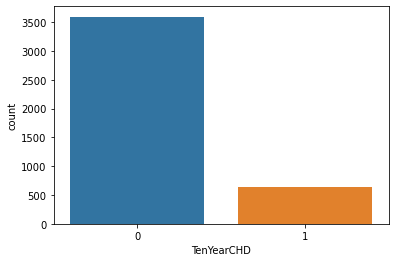

In [5]:
# show boxplot for the reponse variable. The dataset is not balanced
sb.countplot(data = df, x = "TenYearCHD")

In [6]:
#datatypes
df.dtypes

male                 int64
age                  int64
education          float64
currentSmoker        int64
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object

In [7]:
# view empty data rows
df_null_data = df[df.isnull().any(axis=1)]
df_null_data

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
14,0,39,2.0,1,9.0,0.0,0,0,0,226.0,114.0,64.0,22.35,85.0,NaN,0
21,0,43,1.0,0,0.0,0.0,0,0,0,185.0,123.5,77.5,29.89,70.0,NaN,0
26,0,60,1.0,0,0.0,0.0,0,0,0,260.0,110.0,72.5,26.59,65.0,NaN,0
33,1,61,NaN,1,5.0,0.0,0,0,0,175.0,134.0,82.5,18.59,72.0,75.0,1
36,1,56,NaN,0,0.0,0.0,0,0,0,257.0,153.5,102.0,28.09,72.0,75.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4208,0,51,1.0,1,9.0,0.0,0,0,0,340.0,152.0,76.0,25.74,70.0,NaN,0
4229,0,51,3.0,1,20.0,0.0,0,1,0,251.0,140.0,80.0,25.60,75.0,NaN,0
4230,0,56,1.0,1,3.0,0.0,0,1,0,268.0,170.0,102.0,22.89,57.0,NaN,0
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0


In [8]:
# check duplicate patient records
df[df.duplicated()]

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD


In [9]:
# check null data in the dataset
df.isnull().sum()

# replace blank cells with 'NaN'
df.replace(r'^\s*$', np.NaN, regex=True)

# check again
df.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
male,4238.0,0.429212,0.495022,0.00,0.00,0.0,1.000,1.0
age,4238.0,49.584946,8.572160,32.00,42.00,49.0,56.000,70.0
education,4133.0,1.978950,1.019791,1.00,1.00,2.0,3.000,4.0
currentSmoker,4238.0,0.494101,0.500024,0.00,0.00,0.0,1.000,1.0
cigsPerDay,4209.0,9.003089,11.920094,0.00,0.00,0.0,20.000,70.0
BPMeds,4185.0,0.029630,0.169584,0.00,0.00,0.0,0.000,1.0
prevalentStroke,4238.0,0.005899,0.076587,0.00,0.00,0.0,0.000,1.0
prevalentHyp,4238.0,0.310524,0.462763,0.00,0.00,0.0,1.000,1.0
diabetes,4238.0,0.025720,0.158316,0.00,0.00,0.0,0.000,1.0
totChol,4188.0,236.721585,44.590334,107.00,206.00,234.0,263.000,696.0


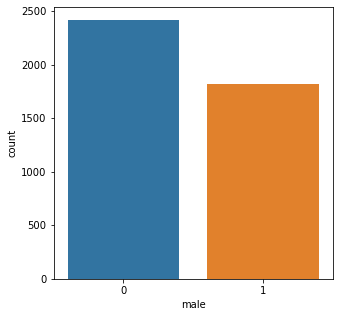

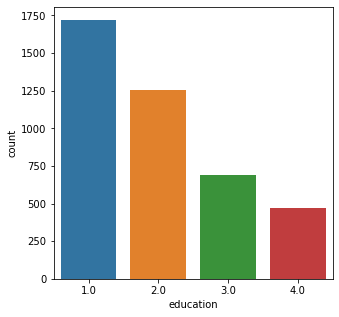

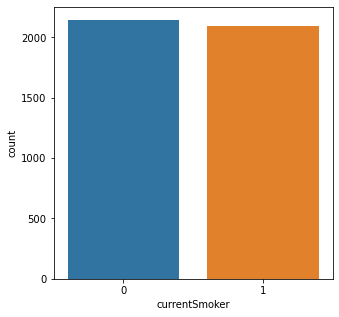

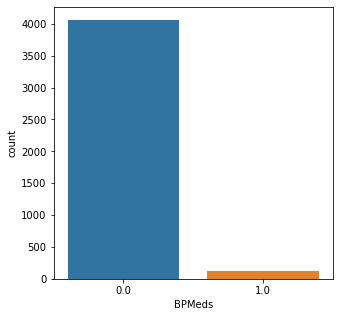

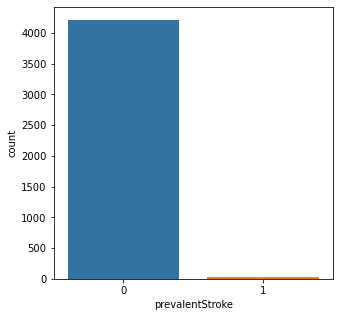

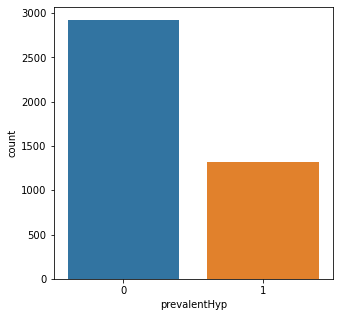

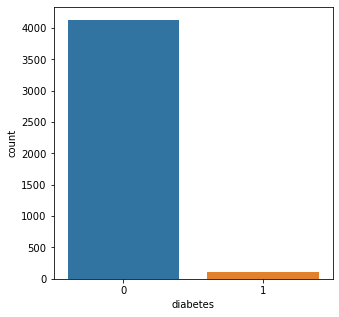

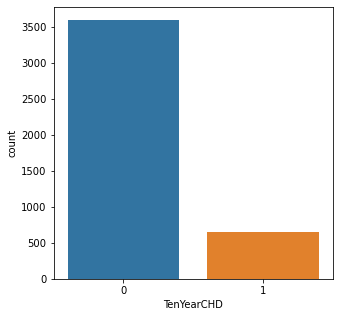

In [11]:
# show bar graphs for all categorical features (nominal)

df_categ = ['male', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'TenYearCHD']

# for loop to display all selected features in df_nominal

for x in df_categ:
    plt.figure(figsize = (5,5))
    sb.countplot(df[x])
    plt.show()
    

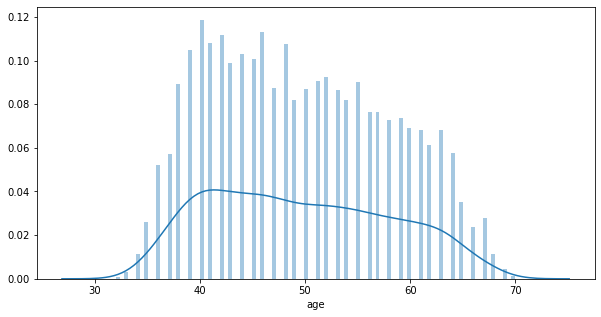

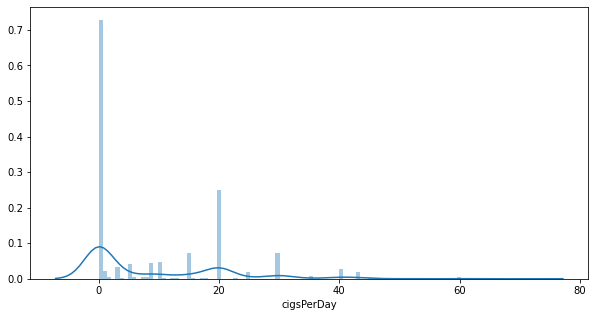

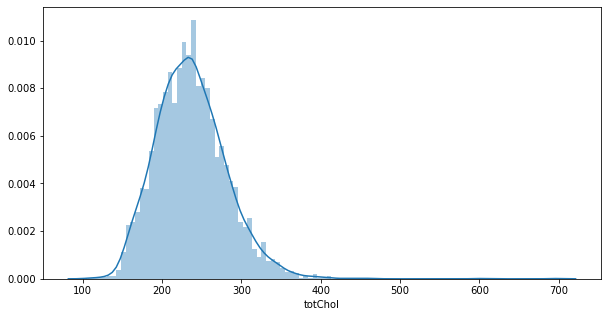

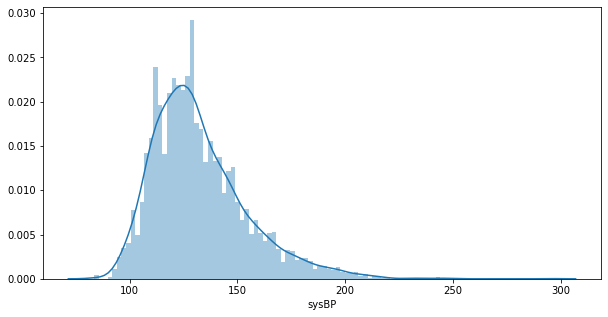

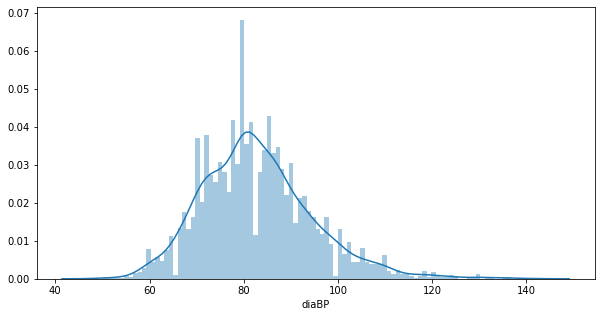

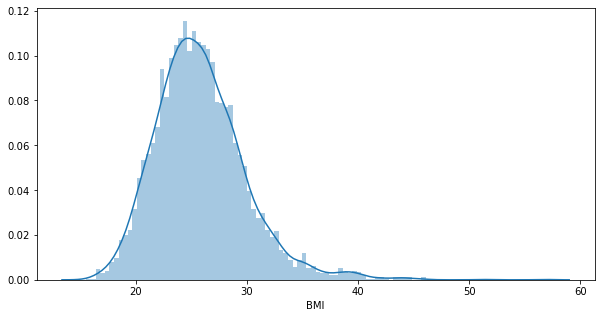

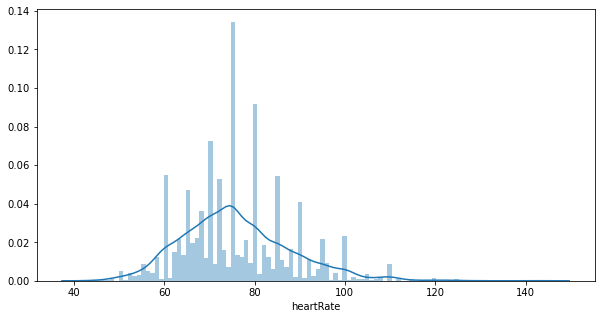

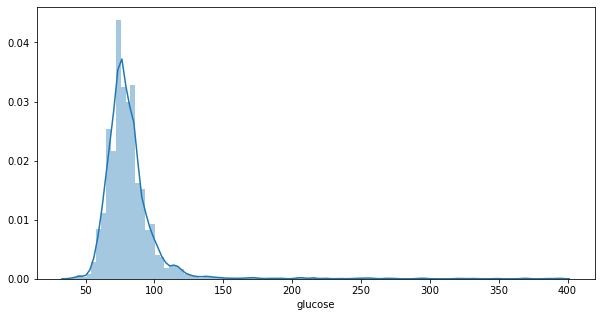

In [12]:
# show distribution graphs for all numerical features (continous)

df_contin = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

# for loop to display all selected features in df_nominal

for x in df_contin:
    plt.figure(figsize = (10,5))
    sb.distplot(df[x], bins = 100)
    plt.show()

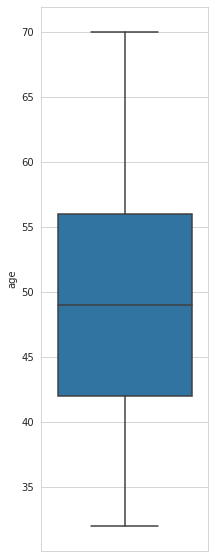

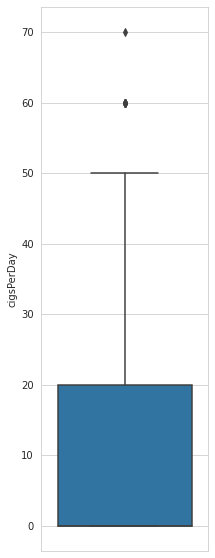

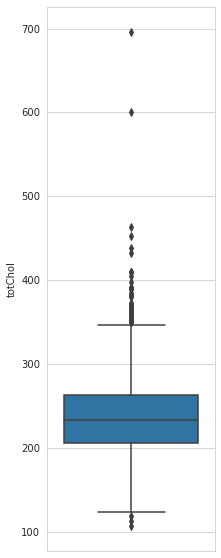

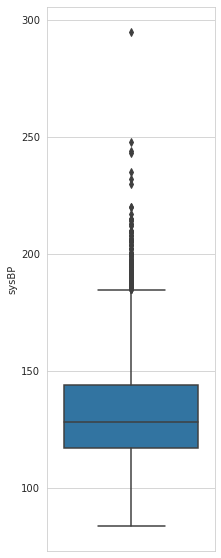

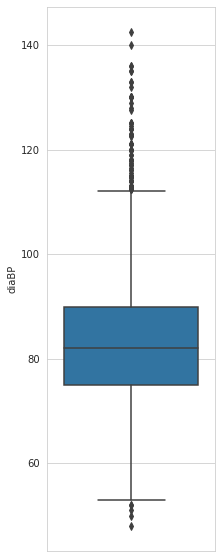

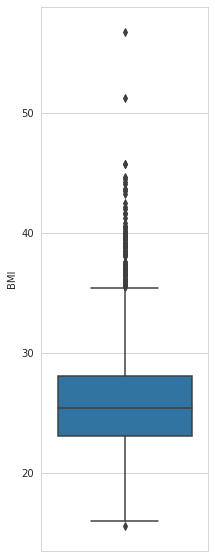

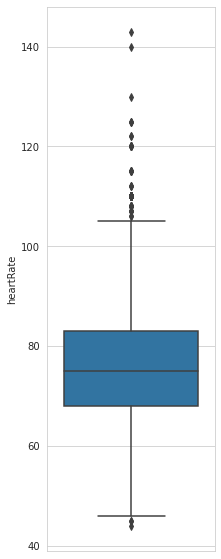

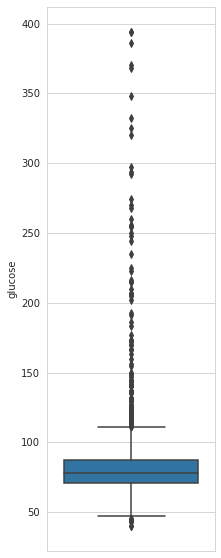

In [13]:
# create and show a set of boxplots for each numerical feature

# ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

for i in df_contin:
    plt.figure(figsize=(3,10))
    sb.set_style("whitegrid")
    sb.boxplot(y = df[i])
    plt.show()

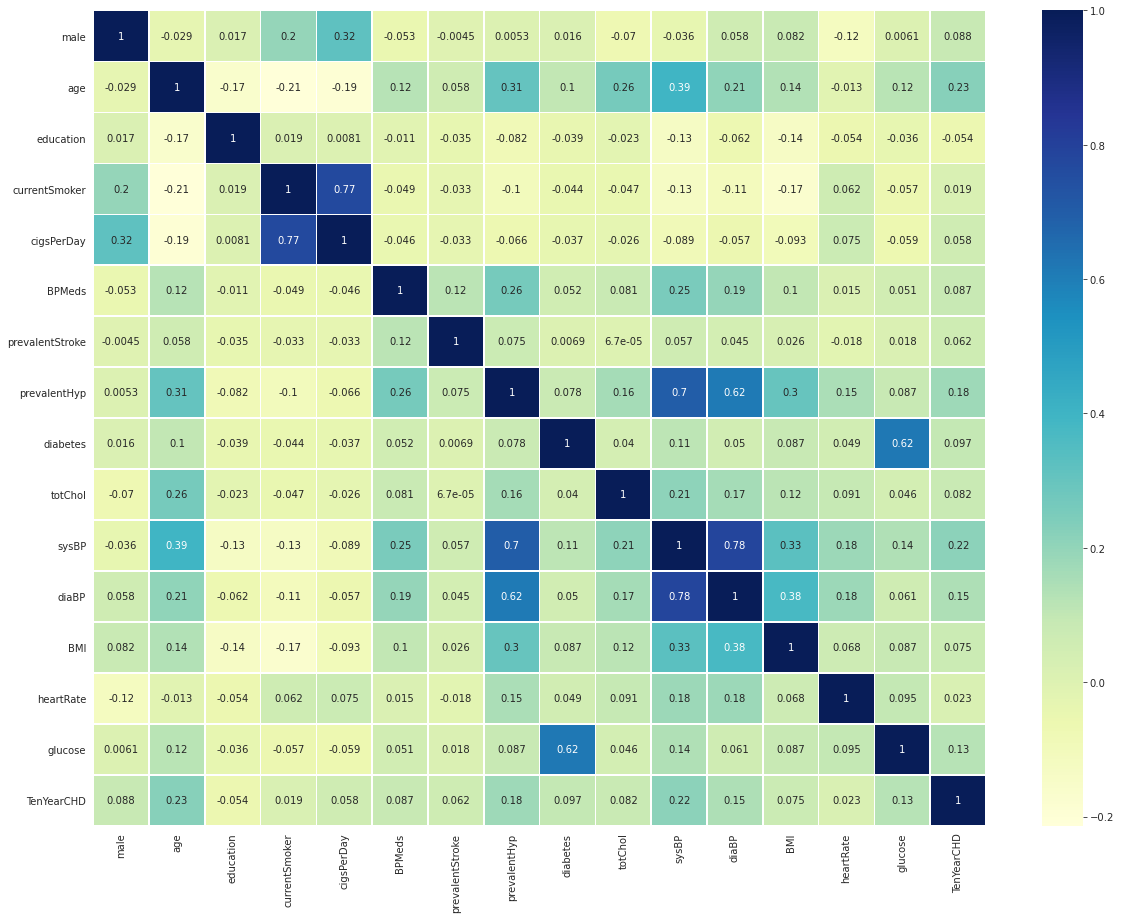

In [14]:
## show correlation plot to check correlation of the features
plt.subplots(figsize=(20,15))
sb.heatmap(df.corr(), cmap = "YlGnBu", annot = True, linewidths=.5)